#### Saturday, August 3, 2024

[llama3-stock-market-function-calling](https://github.com/groq/groq-api-cookbook/blob/main/llama3-stock-market-function-calling/llama3-stock-market-function-calling.ipynb)

mamba activate llama3

This all runs. 

In [1]:
import os
from getpass import getpass

# enter your api key
GROQ_API_KEY = getpass("Enter your API key: ")
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [ ]:
# pip install langchain-groq
# pip install yfinance
# pip install plotly
# pip install -U kaleido

# Function Calling with Llama 3 and LangChain

The tech world is abuzz with the release of [Meta's Llama 3](https://llama.meta.com/llama3/), and Groq is excited to serve this powerful model at industry-leading speeds! Llama 3 [excels at function calling](https://twitter.com/RickLamers/status/1781444639079145722), making it an ideal choice for any function calling application. This cookbook will guide you through using Llama 3 in conjunction with [Groq's LangChain integration](https://python.langchain.com/docs/integrations/chat/groq/) to leverage Yahoo Finance's [yfinance API](https://pypi.org/project/yfinance/) for real-time stock market analysis. We'll demonstrate how to write functions to call the yfinance API from a user prompt, enabling the LLM to provide relevant, real-time information on the stock market, answering a range of questions from users

### Setup

In [2]:
from langchain_groq import ChatGroq
import os
import yfinance as yf
import pandas as pd

As mentioned in the introduction, we will be using Meta's Llama 3-70B model for function calling in this notebook. We are also using LangChain's ```ChatGroq``` function to define our LLM and integrate it with additional LangChain tooling. Note that you will need a Groq API Key to proceed and can create an account [here](https://console.groq.com/) to generate one for free.

In [3]:
llm = ChatGroq(groq_api_key = os.getenv('GROQ_API_KEY'),model = 'llama3-70b-8192')

### Defining Tools

Now we will define two [LangChain tools](https://python.langchain.com/docs/modules/tools/) that leverage the yfinance API to answer user queries. Our goal is to enable the LLM to provide accurate and timely information on any stock, just like you'd get on [Yahoo Finance](https://finance.yahoo.com/quote/META/). We'll focus on two types of information: current data, such as price, volume, and beta, and historical prices. To achieve this, we'll create two tools: ```get_stock_info``` for current information and ```get_historical_price``` for historical prices.

Each tool includes a detailed description that helps the LLM determine which tool to use and which parameters to use. In ```get_stock_info```, we list all the keys available in data.info to ensure that Llama 3 selects the correct key verbatim. In ```get_historical_price```, we explicitly explain the purpose of start_date and end_date and provide guidance on how to fill them. In both functions, we've found that Llama 3 is capable of identifying the correct stock symbol given a company name without additional prompting.

In [4]:
from langchain_core.tools import tool

@tool
def get_stock_info(symbol, key):
    '''Return the correct stock info value given the appropriate symbol and key. Infer valid key from the user prompt; it must be one of the following:

    address1, city, state, zip, country, phone, website, industry, industryKey, industryDisp, sector, sectorKey, sectorDisp, longBusinessSummary, fullTimeEmployees, companyOfficers, auditRisk, boardRisk, compensationRisk, shareHolderRightsRisk, overallRisk, governanceEpochDate, compensationAsOfEpochDate, maxAge, priceHint, previousClose, open, dayLow, dayHigh, regularMarketPreviousClose, regularMarketOpen, regularMarketDayLow, regularMarketDayHigh, dividendRate, dividendYield, exDividendDate, beta, trailingPE, forwardPE, volume, regularMarketVolume, averageVolume, averageVolume10days, averageDailyVolume10Day, bid, ask, bidSize, askSize, marketCap, fiftyTwoWeekLow, fiftyTwoWeekHigh, priceToSalesTrailing12Months, fiftyDayAverage, twoHundredDayAverage, currency, enterpriseValue, profitMargins, floatShares, sharesOutstanding, sharesShort, sharesShortPriorMonth, sharesShortPreviousMonthDate, dateShortInterest, sharesPercentSharesOut, heldPercentInsiders, heldPercentInstitutions, shortRatio, shortPercentOfFloat, impliedSharesOutstanding, bookValue, priceToBook, lastFiscalYearEnd, nextFiscalYearEnd, mostRecentQuarter, earningsQuarterlyGrowth, netIncomeToCommon, trailingEps, forwardEps, pegRatio, enterpriseToRevenue, enterpriseToEbitda, 52WeekChange, SandP52WeekChange, lastDividendValue, lastDividendDate, exchange, quoteType, symbol, underlyingSymbol, shortName, longName, firstTradeDateEpochUtc, timeZoneFullName, timeZoneShortName, uuid, messageBoardId, gmtOffSetMilliseconds, currentPrice, targetHighPrice, targetLowPrice, targetMeanPrice, targetMedianPrice, recommendationMean, recommendationKey, numberOfAnalystOpinions, totalCash, totalCashPerShare, ebitda, totalDebt, quickRatio, currentRatio, totalRevenue, debtToEquity, revenuePerShare, returnOnAssets, returnOnEquity, freeCashflow, operatingCashflow, earningsGrowth, revenueGrowth, grossMargins, ebitdaMargins, operatingMargins, financialCurrency, trailingPegRatio
    
    If asked generically for 'stock price', use currentPrice
    '''
    data = yf.Ticker(symbol)
    stock_info = data.info
    return stock_info[key]


@tool
def get_historical_price(symbol, start_date, end_date):
    """
    Fetches historical stock prices for a given symbol from 'start_date' to 'end_date'.
    - symbol (str): Stock ticker symbol.
    - end_date (date): Typically today unless a specific end date is provided. End date MUST be greater than start date
    - start_date (date): Set explicitly, or calculated as 'end_date - date interval' (for example, if prompted 'over the past 6 months', date interval = 6 months so start_date would be 6 months earlier than today's date). Default to '1900-01-01' if vaguely asked for historical price. Start date must always be before the current date
    """

    data = yf.Ticker(symbol)
    hist = data.history(start=start_date, end=end_date)
    hist = hist.reset_index()
    hist[symbol] = hist['Close']
    return hist[['Date', symbol]]


### Using our Tools

Now we will chain our tools together and bind them with our LLM so that they can be accessed:

In [5]:
tools = [get_stock_info, get_historical_price]
llm_with_tools = llm.bind_tools(tools)

Let's test our function calling with a few simple prompts:

In [6]:
query1 = 'What is the market cap of Meta?'
query2 = 'How does the volume of Apple compare to that of Microsoft?'

print(llm_with_tools.invoke(query1).tool_calls)
print(llm_with_tools.invoke(query2).tool_calls)

[{'name': 'get_stock_info', 'args': {'symbol': 'META', 'key': 'marketCap'}, 'id': 'call_xrxp', 'type': 'tool_call'}]
[{'name': 'get_stock_info', 'args': {'symbol': 'AAPL', 'key': 'volume'}, 'id': 'call_a1f4', 'type': 'tool_call'}, {'name': 'get_stock_info', 'args': {'symbol': 'MSFT', 'key': 'volume'}, 'id': 'call_0x6n', 'type': 'tool_call'}]


As you can see, in our first query we successfully called ```get_stock_info``` with parameters **META** and **marketCap**, which are valid stock symbols and keys, respectively. In our second query, the LLM correctly called ```get_stock_info``` twice for Apple and Microsoft.

In [7]:
query1 = 'Show the historical price of the S&P 500 over the past 3 years? (Today is 4/23/2024)'
query2 = 'Compare the price of Google and Amazon throughout 2023'

print(llm_with_tools.invoke(query1).tool_calls)
print(llm_with_tools.invoke(query2).tool_calls)

[{'name': 'get_historical_price', 'args': {'symbol': '^GSPC', 'start_date': '2021-04-23', 'end_date': '2024-04-23'}, 'id': 'call_5pbm', 'type': 'tool_call'}]
[{'name': 'get_historical_price', 'args': {'symbol': 'GOOG', 'start_date': '2023-01-01', 'end_date': '2023-12-31'}, 'id': 'call_gv7h', 'type': 'tool_call'}, {'name': 'get_historical_price', 'args': {'symbol': 'AMZN', 'start_date': '2023-01-01', 'end_date': '2023-12-31'}, 'id': 'call_zydd', 'type': 'tool_call'}]


Our tool calling LLM also correctly identified ```get_historical_price``` for historical price questions, and appropriately called it twice. Note that to perform any kind of lookback analysis, you'll need to provide the current date.

### Putting it all together

This function, ```plot_price_over_time```, is not called by the LLM but will plot historical price over time if ```get_historical_price``` is called:

In [8]:
import pandas as pd
import plotly.graph_objects as go

def plot_price_over_time(historical_price_dfs):

    full_df = pd.DataFrame(columns = ['Date'])
    for df in historical_price_dfs:
        full_df = full_df.merge(df, on = 'Date', how = 'outer')

    # Create a Plotly figure
    fig = go.Figure()
    
    # Dynamically add a trace for each stock symbol in the DataFrame
    for column in full_df.columns[1:]:  # Skip the first column since it's the date
        fig.add_trace(go.Scatter(x=full_df['Date'], y=full_df[column], mode='lines+markers', name=column))
    
    
    # Update the layout to add titles and format axis labels
    fig.update_layout(
        title='Stock Price Over Time: ' + ', '.join(full_df.columns.tolist()[1:]),
        xaxis_title='Date',
        yaxis_title='Stock Price (USD)',
        yaxis_tickprefix='$',
        yaxis_tickformat=',.2f',
        xaxis=dict(
            tickangle=-45,
            nticks=20,
            tickfont=dict(size=10),
        ),
        yaxis=dict(
            showgrid=True,   # Enable y-axis grid lines
            gridcolor='lightgrey',  # Set grid line color
        ),
        legend_title_text='Stock Symbol',
        plot_bgcolor='white',  # Set plot background to white
        paper_bgcolor='white',  # Set overall figure background to white
        legend=dict(
            bgcolor='white',  # Optional: Set legend background to white
            bordercolor='black'
        )
    )
    
    # Show the figure - unfortunately dynamic charts are not supported on GitHub preview, so this just generates
    # a static .png. If running locally, you can use fig.show(renderer='iframe') to output a dynamic plotly plot
    fig.show('png')


Finally, we will use LangChain to tie everything together. Our system prompt will provide the current date for context, and our function will execute each subsequent tool that's been called. It will also send the output back to the LLM so that it can respond to the user prompt with relevant information, and plot historical prices if that's what was asked for:

In [9]:
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from datetime import date

def call_functions(llm_with_tools, user_prompt):
    system_prompt = 'You are a helpful finance assistant that analyzes stocks and stock prices. Today is {today}'.format(today = date.today())
    
    messages = [SystemMessage(system_prompt), HumanMessage(user_prompt)]
    ai_msg = llm_with_tools.invoke(messages)
    messages.append(ai_msg)
    historical_price_dfs = []
    symbols = []
    for tool_call in ai_msg.tool_calls:
        selected_tool = {"get_stock_info": get_stock_info, "get_historical_price": get_historical_price}[tool_call["name"].lower()]
        tool_output = selected_tool.invoke(tool_call["args"])
        if tool_call['name'] == 'get_historical_price':
            historical_price_dfs.append(tool_output)
            symbols.append(tool_output.columns[1])
        else:
            messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))
    
    if len(historical_price_dfs) > 0:
        plot_price_over_time(historical_price_dfs)
        symbols = ' and '.join(symbols)
        messages.append(ToolMessage('Tell the user that a historical stock price chart for {symbols} been generated.'.format(symbols=symbols), tool_call_id=0))

    return llm_with_tools.invoke(messages).content


In [10]:
user_prompt = 'What is the beta for meta stock?'
call_functions(llm_with_tools, user_prompt)

'The beta for Meta stock is 1.212.'

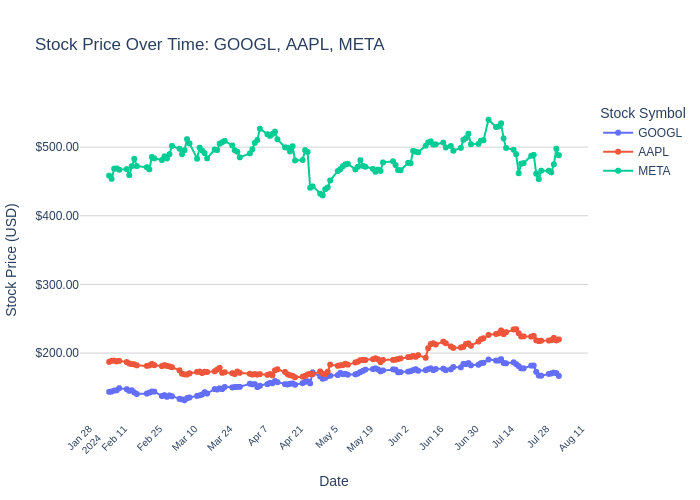

'A historical stock price chart for GOOGL, AAPL, and META has been generated. You can now compare the stock prices of these companies over the past 6 months.'

In [11]:
user_prompt = "Compare the stock price of Google, Apple and Meta over the past 6 months"
call_functions(llm_with_tools, user_prompt)

### Conclusion

In this notebook, we've demonstrated how to harness the power of Groq API's function calling with Llama 3 and LangChain integration. Llama 3 is an impressive new model, and its capabilities are amplified when combined with Groq's exceptional LPU speed! To explore the interactive app that accompanies this notebook, please visit: https://llama3-function-calling.streamlit.app/